In [2]:
%load_ext autoreload
%autoreload 2
from calibrate import *
import matplotlib.pyplot as plt
import numpy as np
import skimage

In [48]:
master_bias('/home/felix/PiCamera_DSLR_like_controller/calibration/Bias', '/home/felix/PiCamera_DSLR_like_controller/calibration/computed')
mbias = np.load('/home/felix/PiCamera_DSLR_like_controller/calibration/computed/master_bias.npy')/(2**16-1)*255


In [ ]:
plt.plot(mbias/(2**16-1)*255)

In [4]:
master_flat(img_dir='/home/felix/PiCamera_DSLR_like_controller/calibration/Flats',out_dir='/home/felix/PiCamera_DSLR_like_controller/calibration/computed', mbias='/home/felix/PiCamera_DSLR_like_controller/calibration/computed/master_bias.npy',mdark=None)
mflat = np.load('/home/felix/PiCamera_DSLR_like_controller/calibration/computed/master_flat.npy')


In [ ]:
plt.plot(mflat)

### Couldnt crack lens dist

# Image gen

In [5]:
img_dir = '/home/felix/Pictures/Ladybug_EO_trials/composite/img_6'
# These are uint16
mflat = np.load('/home/felix/PiCamera_DSLR_like_controller/calibration/computed/master_flat.npy')
mbias = np.load('/home/felix/PiCamera_DSLR_like_controller/calibration/computed/master_bias.npy')/(2**16-1)*255
os.mkdir(os.path.join(img_dir,'preprocessed'))
for i in os.listdir(img_dir):
    try:
        processed = (np.asarray(Image.open(os.path.join(img_dir, i))) - mbias)/mflat
        processed[processed>255] = 255
        processed[processed<0] = 0
        processed = processed.astype(np.uint8)
        Image.fromarray(processed).save(os.path.join(img_dir,'preprocessed',i))
    except Exception as e:
        print('failed: ', e)
        print(i)

    


failed:  [Errno 21] Is a directory: '/home/felix/Pictures/Ladybug_EO_trials/composite/img_6/preprocessed'
preprocessed


In [6]:
gray_projection = 'l-star'
contrast_window_size = 50
contrast_edge_scale = 0
os.chdir(os.path.join(img_dir,'preprocessed'))
cmd = 'enfuse -o result.tiff --exposure-weight=0 --saturation-weight=0 --contrast-weight=1 --hard-mask --gray-projector={} --contrast-window-size={} --contrast-edge-scale=-0.1 *.png'.format(gray_projection,contrast_window_size,contrast_edge_scale)
os.system(cmd)

enfuse: warning: contrast window size "50" is even; increasing size to next odd number
enfuse: info: input image "05122023-21:55:20.png" does not have an alpha channel;
enfuse: note: assuming all pixels should contribute to the final image
enfuse: info: input image "05122023-21:55:28.png" does not have an alpha channel;
enfuse: note: assuming all pixels should contribute to the final image
enfuse: info: input image "05122023-21:56:01.png" does not have an alpha channel;
enfuse: note: assuming all pixels should contribute to the final image
enfuse: info: input image "05122023-21:56:16.png" does not have an alpha channel;
enfuse: note: assuming all pixels should contribute to the final image
enfuse: info: input image "05122023-21:56:27.png" does not have an alpha channel;
enfuse: note: assuming all pixels should contribute to the final image
enfuse: info: input image "05122023-21:56:34.png" does not have an alpha channel;
enfuse: note: assuming all pixels should contribute to the final i

0

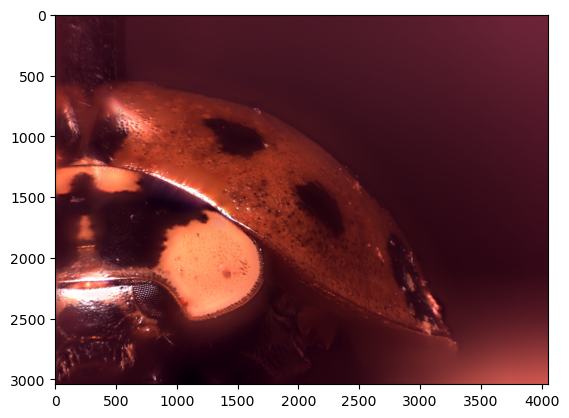

In [7]:
plt.imshow(Image.open(os.path.join(img_dir,'preprocessed','result.tiff')))